학습은 kaggle에 미리 받아놓은 데이터셋을 다운로드 받아서 colab에서 진행했습니다.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("geon05/dataset2")

print("Path to dataset files:", path)

100%|██████████| 17.7G/17.7G [02:00<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/geon05/dataset2/versions/1


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 216MB/s]
Epoch 1/60 - Validation: 100%|██████████| 198/198 [02:22<00:00,  1.39it/s]


Epoch 1/60
  Training Loss: 0.0234
  Validation Loss: 0.0050
  Best model saved with Validation Loss: 0.0050


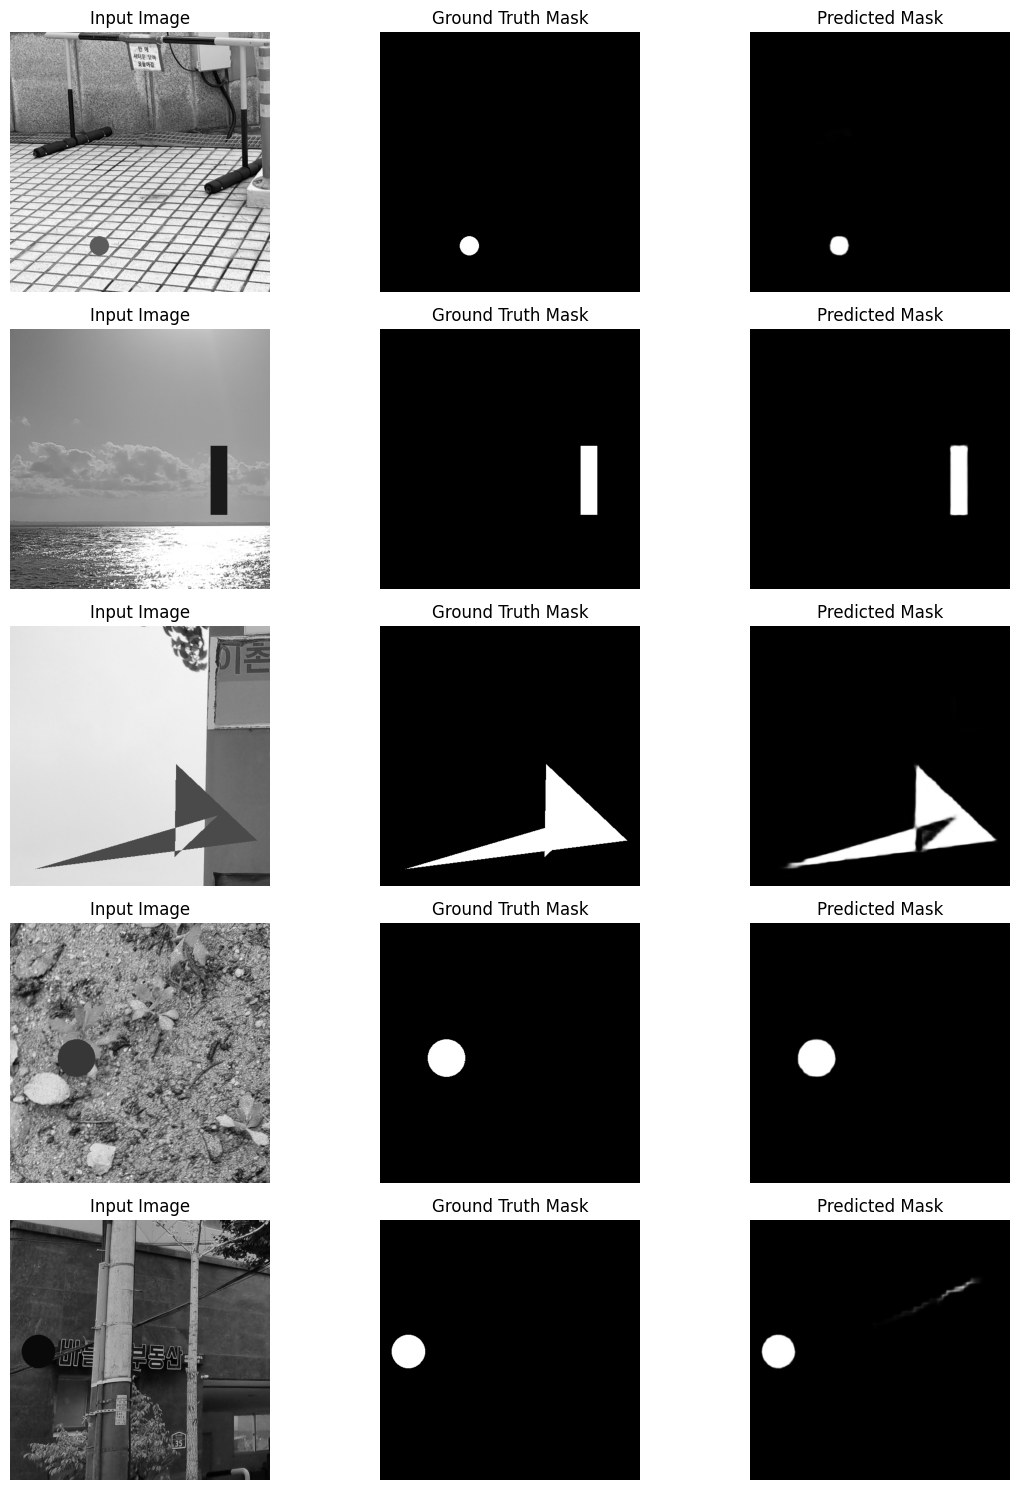

Epoch 2/60 - Validation: 100%|██████████| 198/198 [02:23<00:00,  1.38it/s]


Epoch 2/60
  Training Loss: 0.0051
  Validation Loss: 0.0064


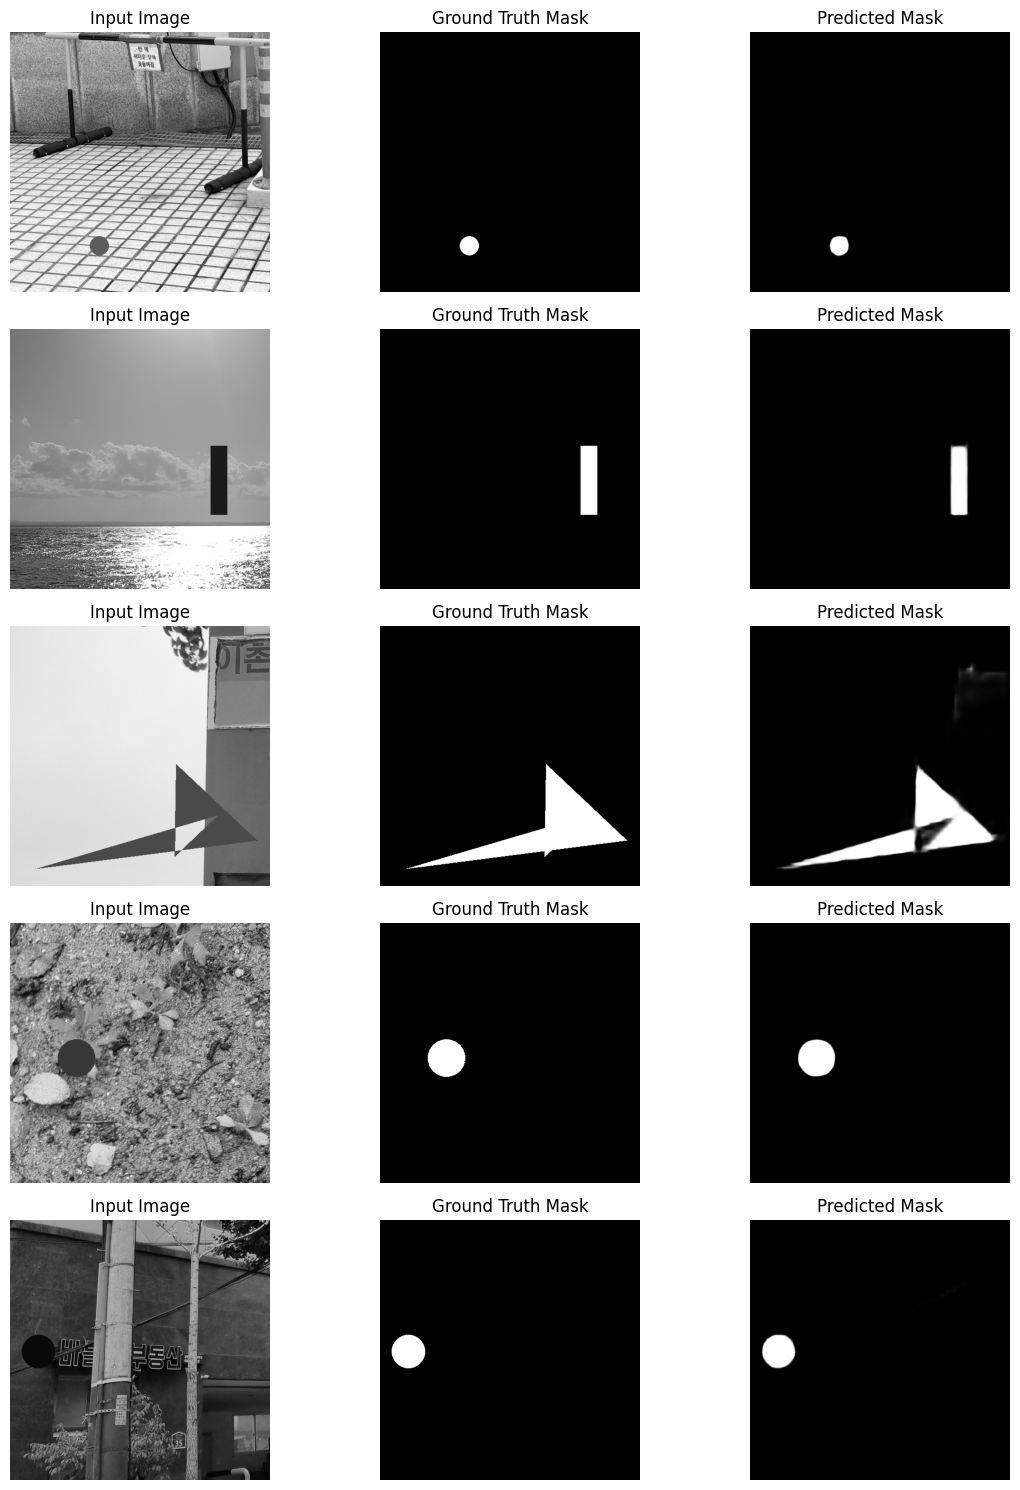

Epoch 3/60 - Validation: 100%|██████████| 198/198 [02:23<00:00,  1.38it/s]


Epoch 3/60
  Training Loss: 0.0034
  Validation Loss: 0.0029
  Best model saved with Validation Loss: 0.0029


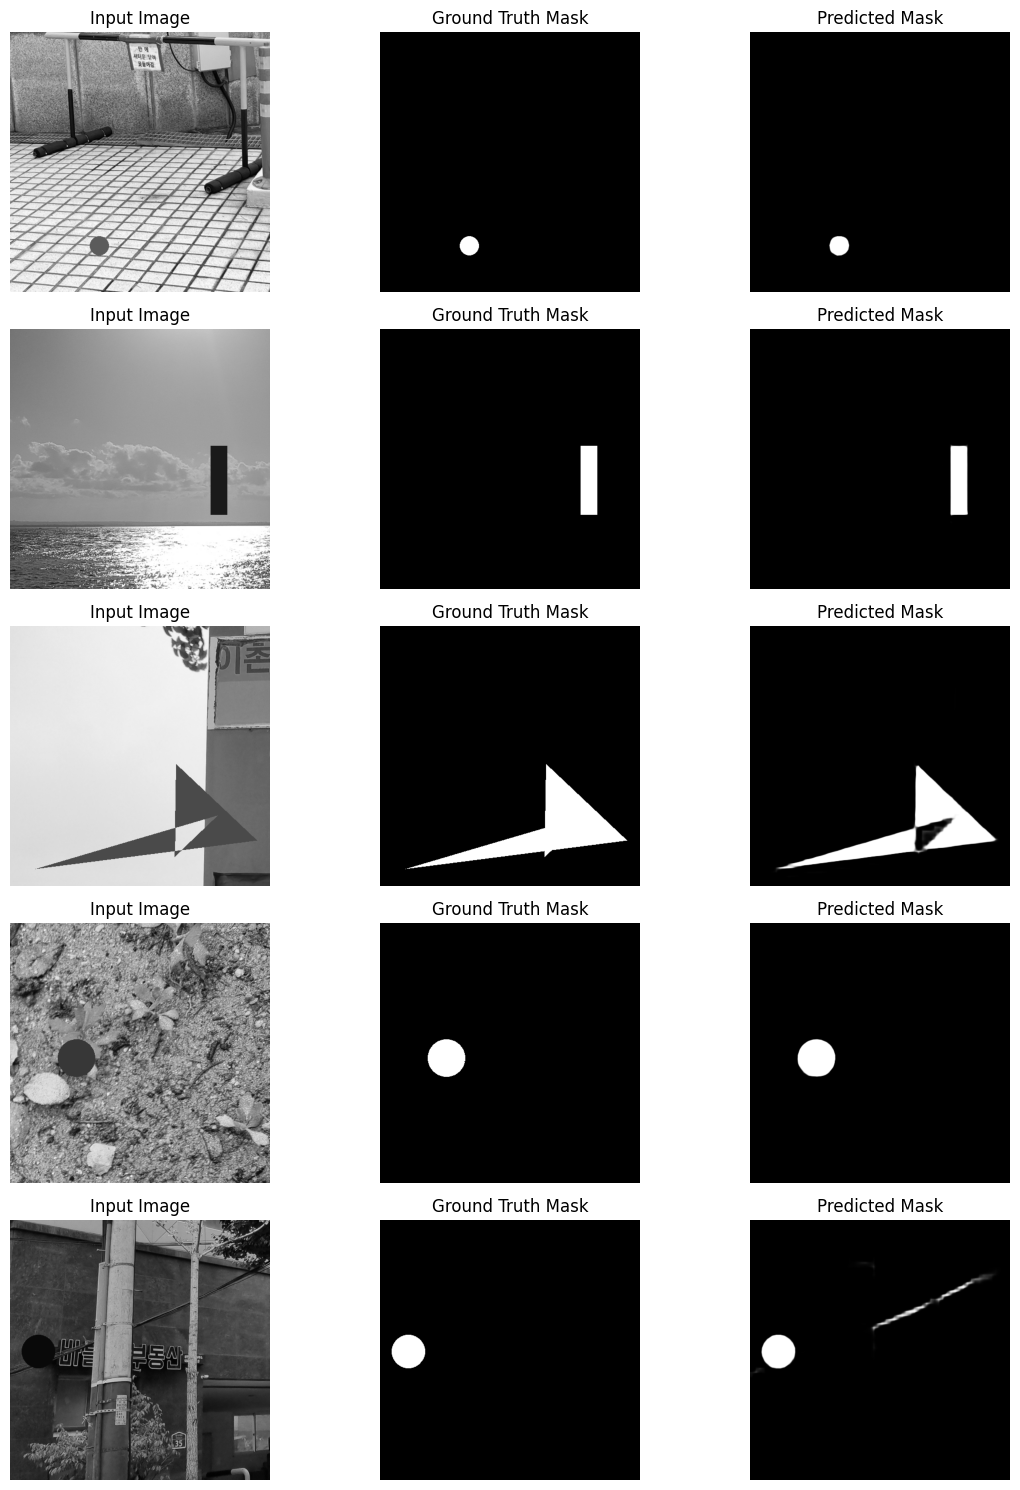

Epoch 4/60 - Validation: 100%|██████████| 198/198 [02:23<00:00,  1.38it/s]


Epoch 4/60
  Training Loss: 0.0054
  Validation Loss: 0.0042


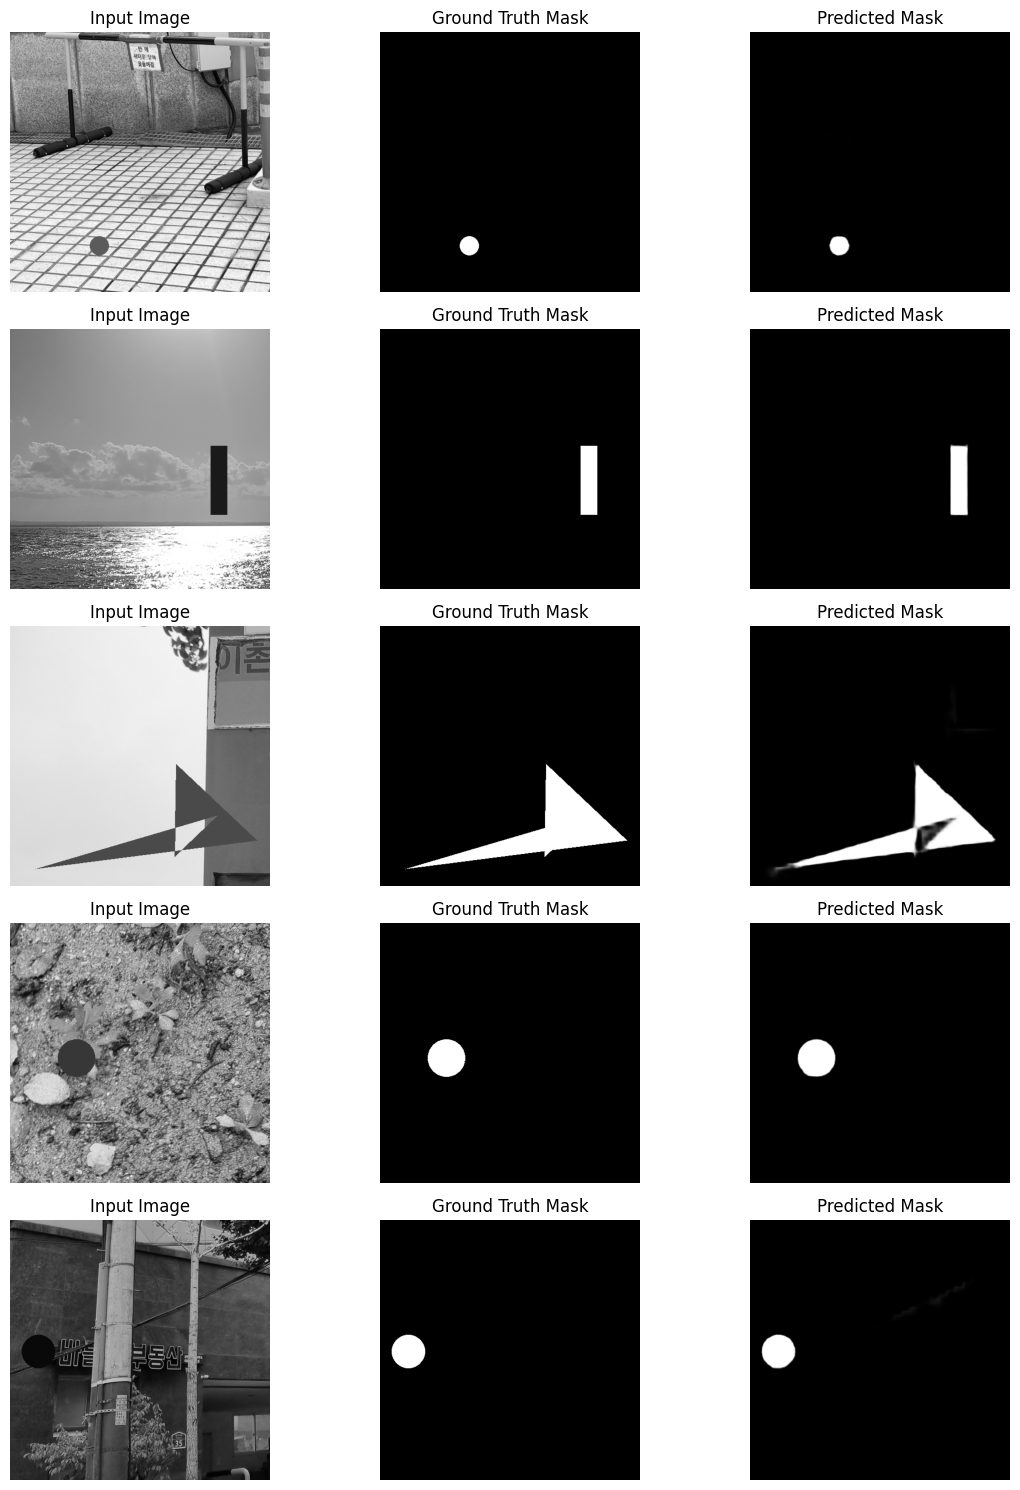

Epoch 5/60 - Validation: 100%|██████████| 198/198 [02:23<00:00,  1.38it/s]


Epoch 5/60
  Training Loss: 0.0038
  Validation Loss: 0.0034


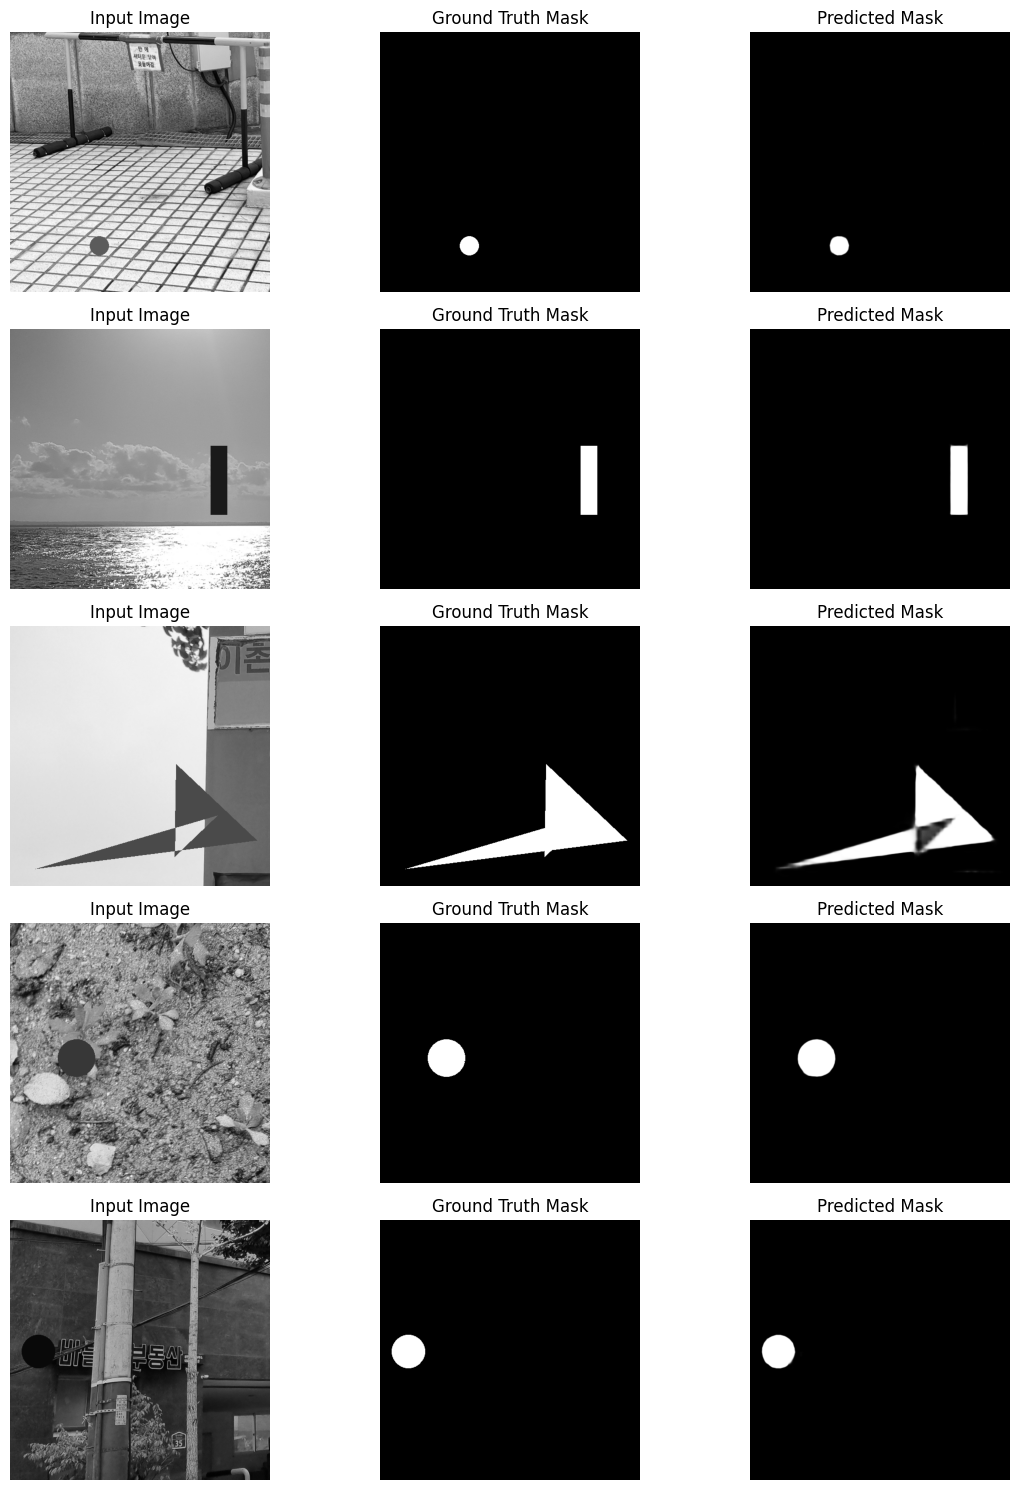

Epoch 6/60 - Validation: 100%|██████████| 198/198 [02:23<00:00,  1.38it/s]


Epoch 6/60
  Training Loss: 0.0029
  Validation Loss: 0.0025
  Best model saved with Validation Loss: 0.0025


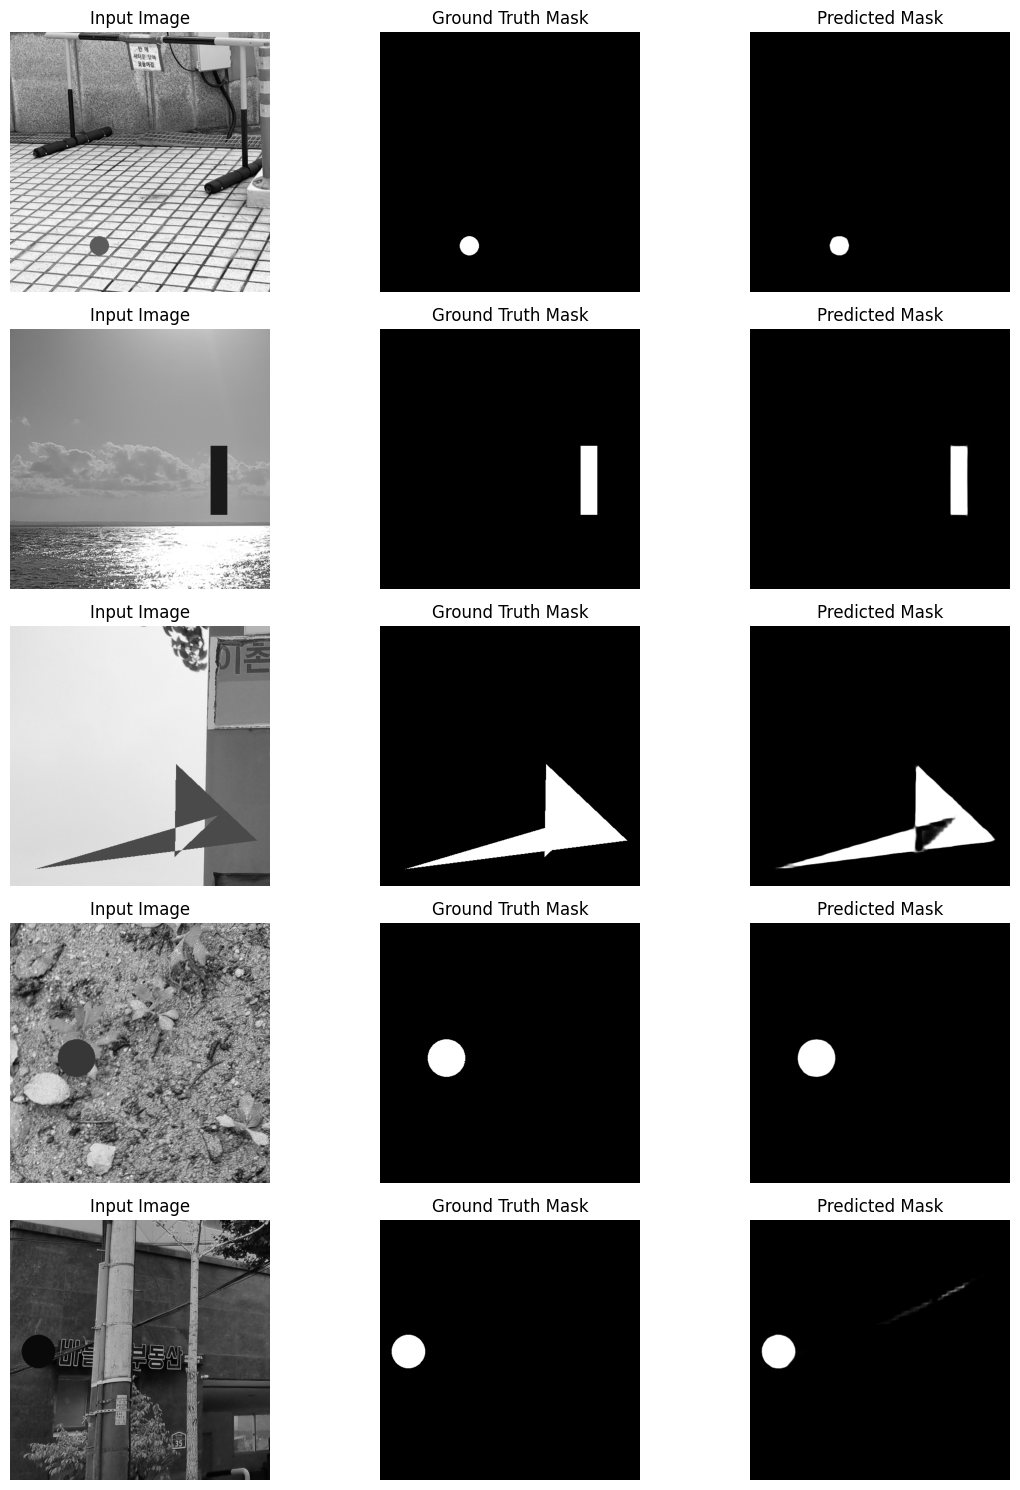

Epoch 7/60 - Validation: 100%|██████████| 198/198 [02:25<00:00,  1.36it/s]


Epoch 7/60
  Training Loss: 0.0024
  Validation Loss: 0.0022
  Best model saved with Validation Loss: 0.0022


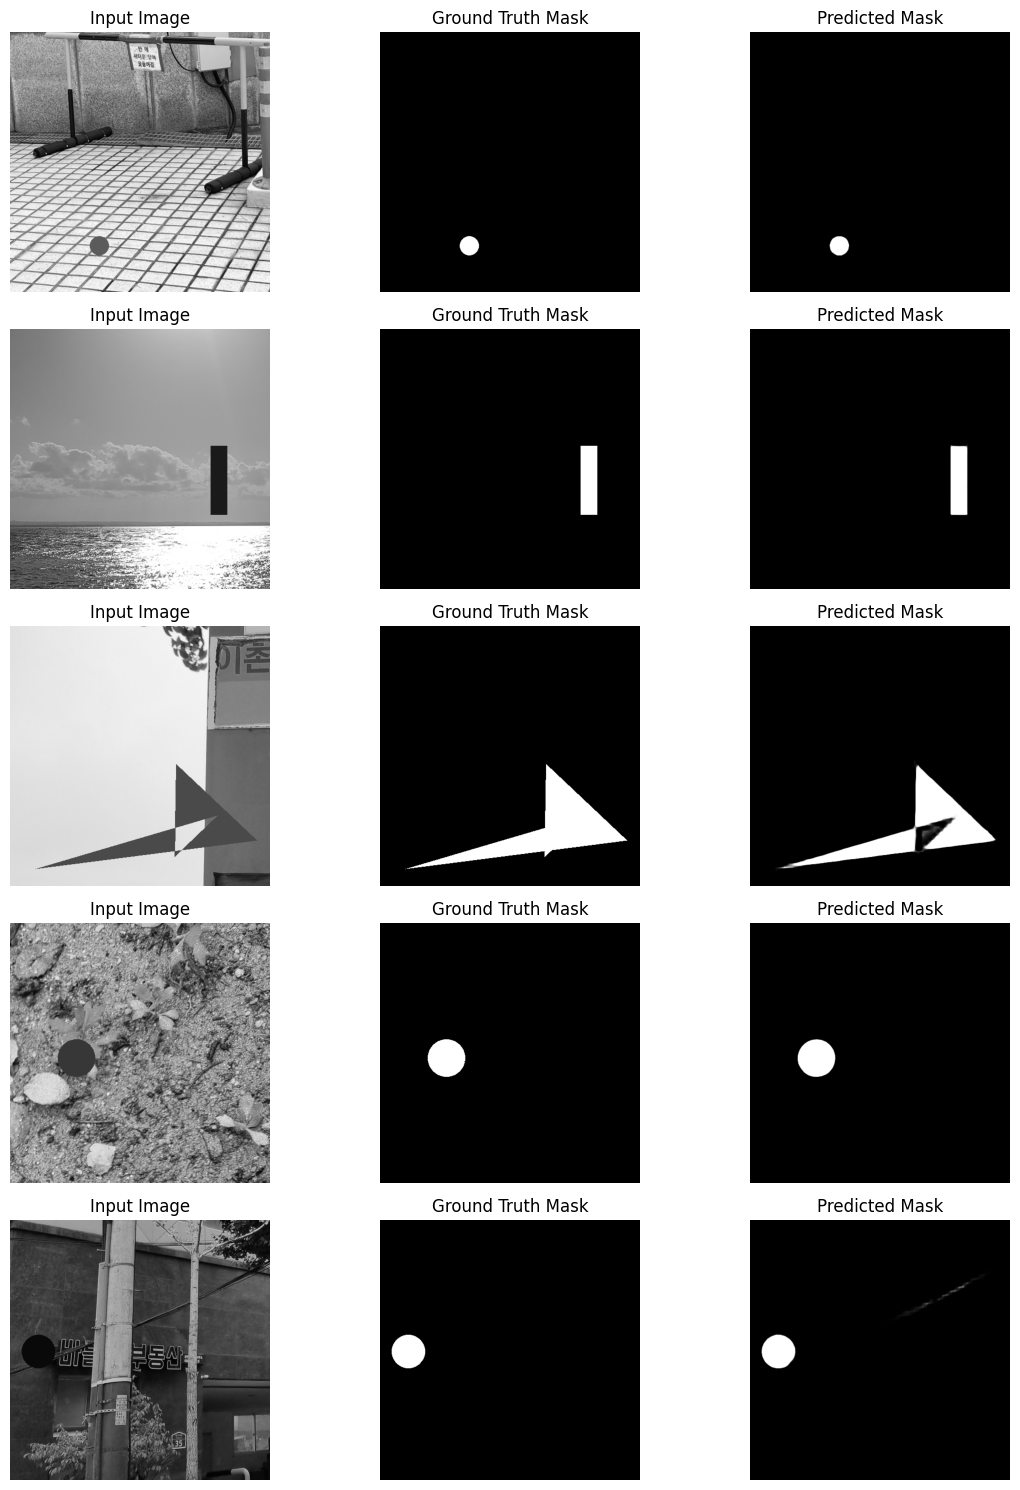

Epoch 8/60 - Validation: 100%|██████████| 198/198 [02:22<00:00,  1.39it/s]


Epoch 8/60
  Training Loss: 0.0043
  Validation Loss: 0.0024


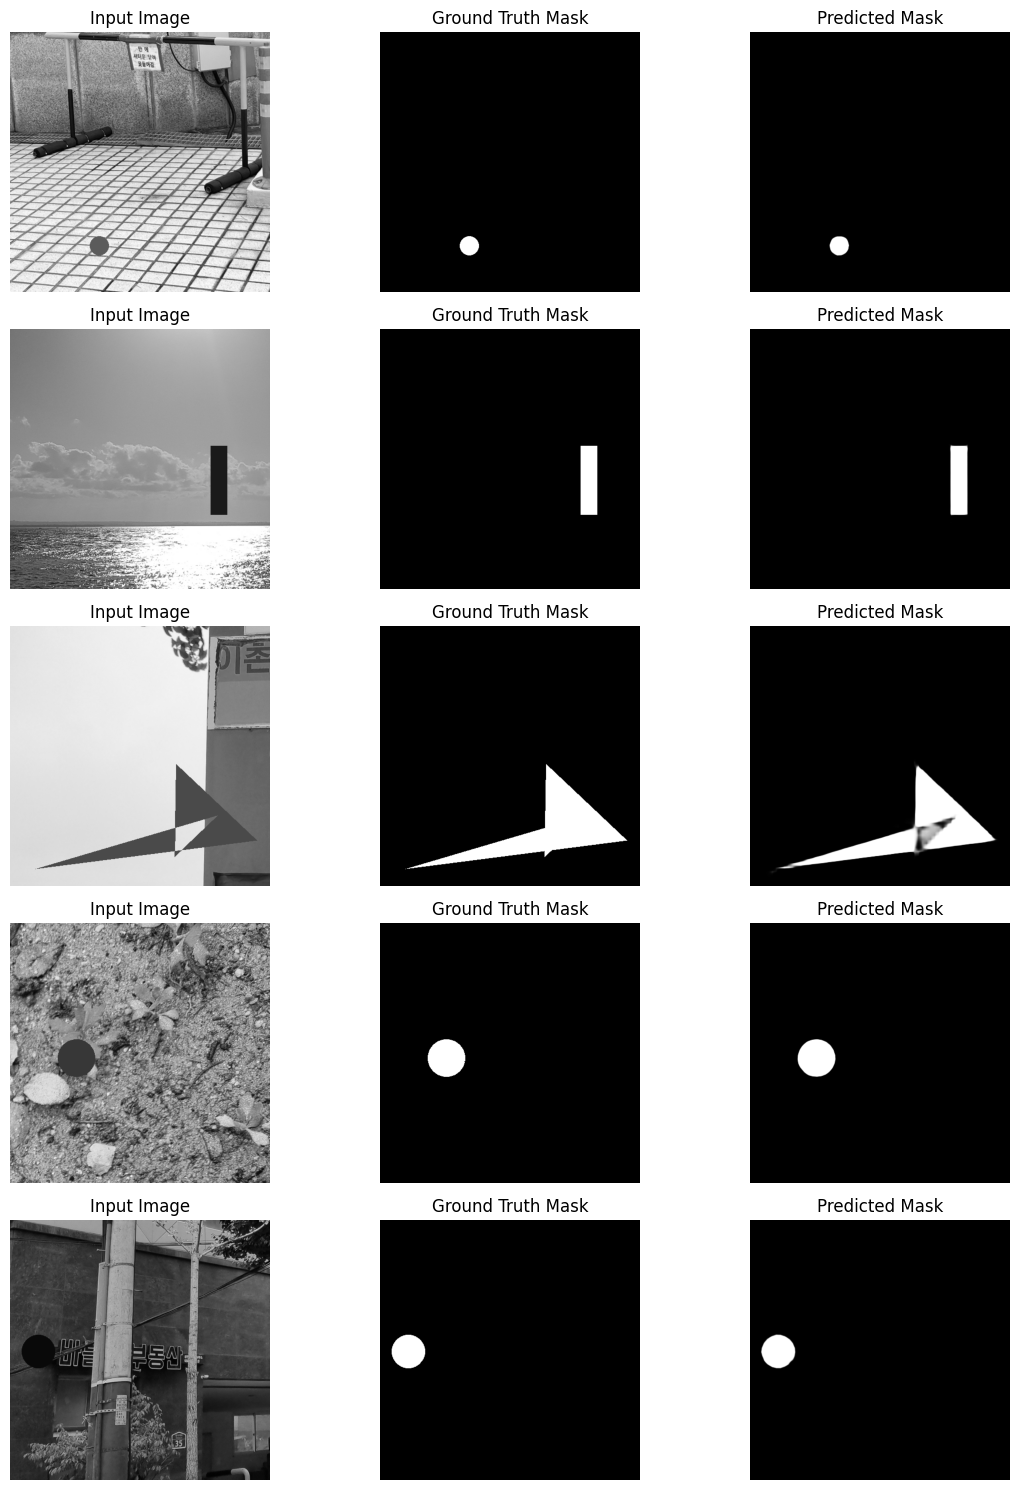

Epoch 9/60 - Validation: 100%|██████████| 198/198 [02:21<00:00,  1.40it/s]


Epoch 9/60
  Training Loss: 0.0025
  Validation Loss: 0.0022


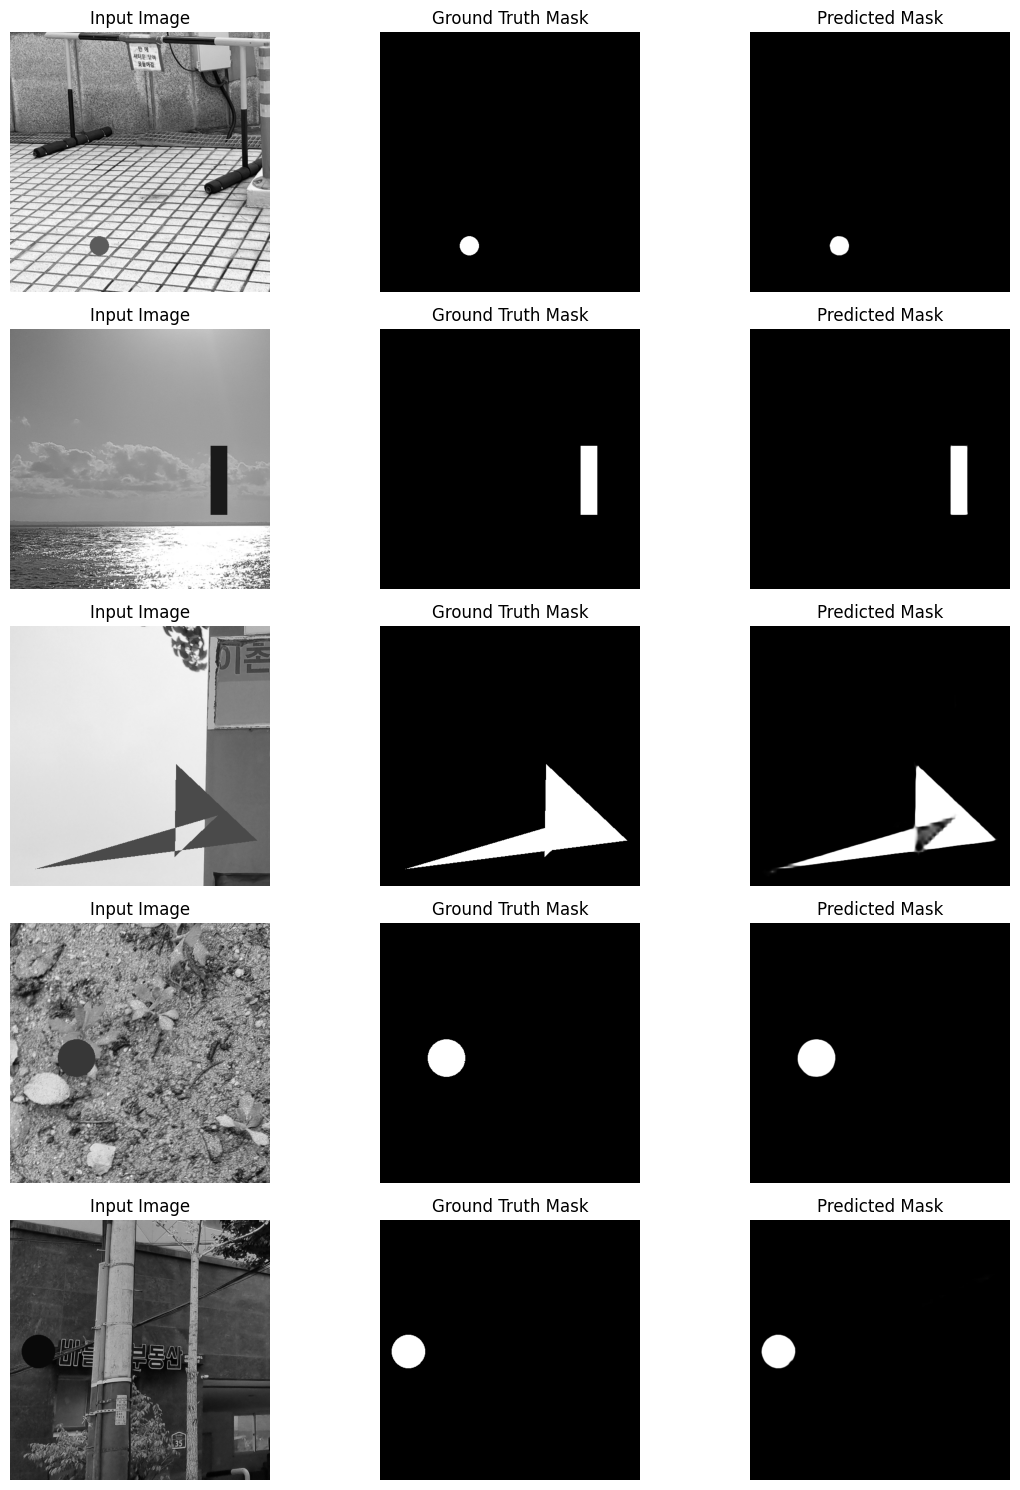

Epoch 10/60 - Validation: 100%|██████████| 198/198 [02:22<00:00,  1.39it/s]


Epoch 10/60
  Training Loss: 0.0020
  Validation Loss: 0.0019
  Best model saved with Validation Loss: 0.0019


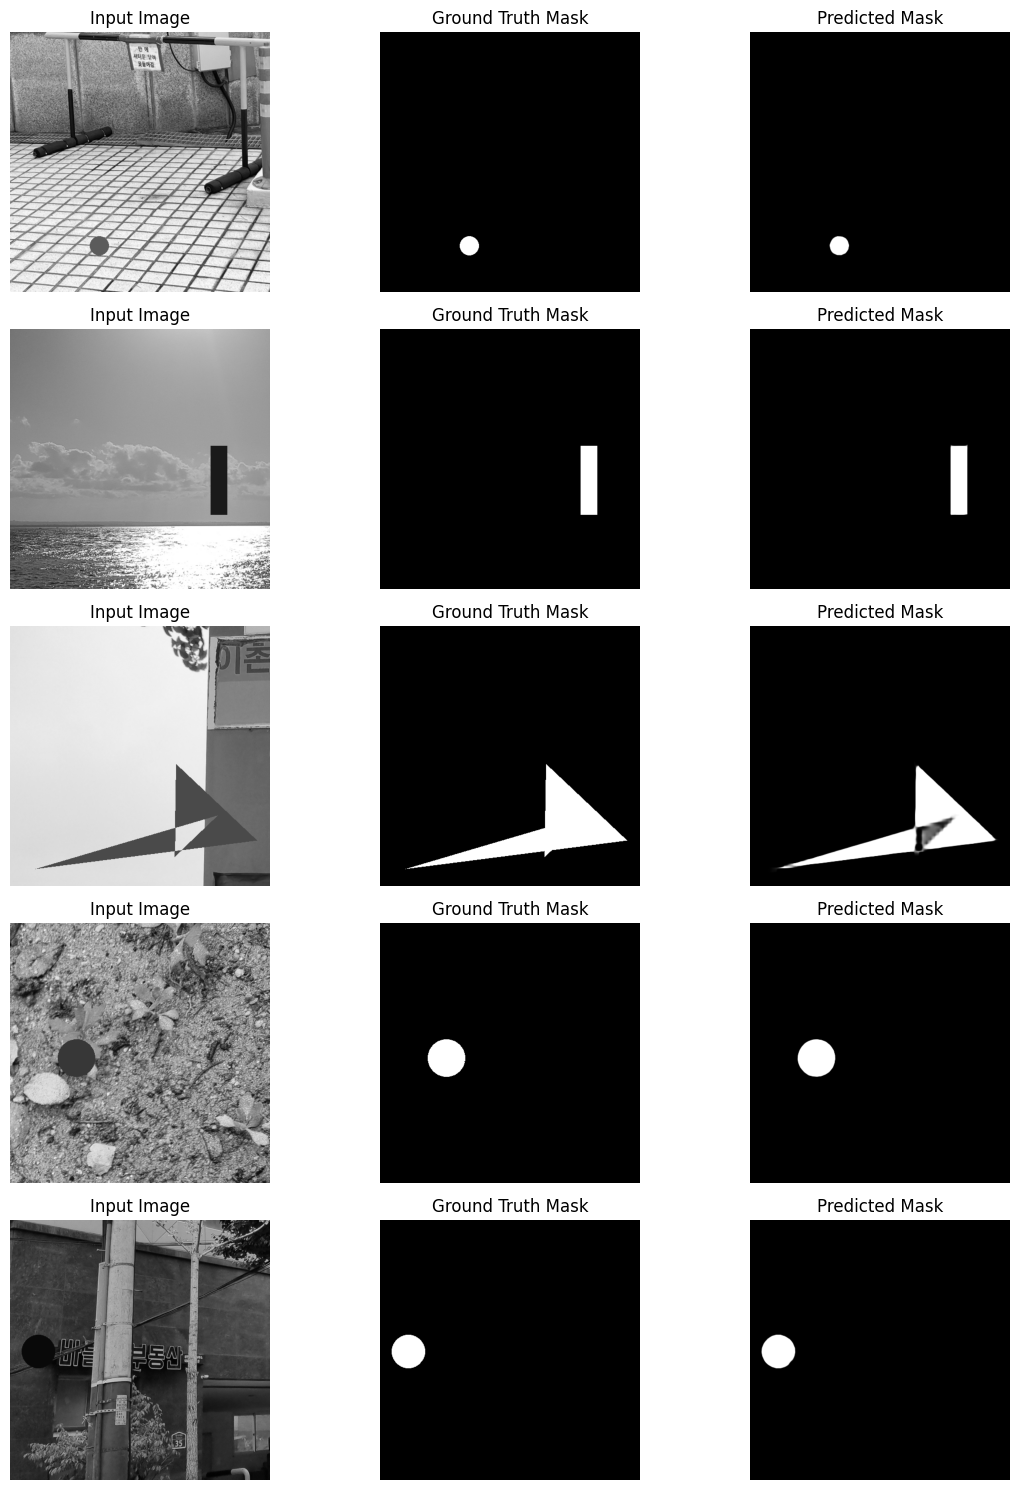

Epoch 11/60 - Validation: 100%|██████████| 198/198 [02:22<00:00,  1.39it/s]


Epoch 11/60
  Training Loss: 0.0038
  Validation Loss: 0.0028


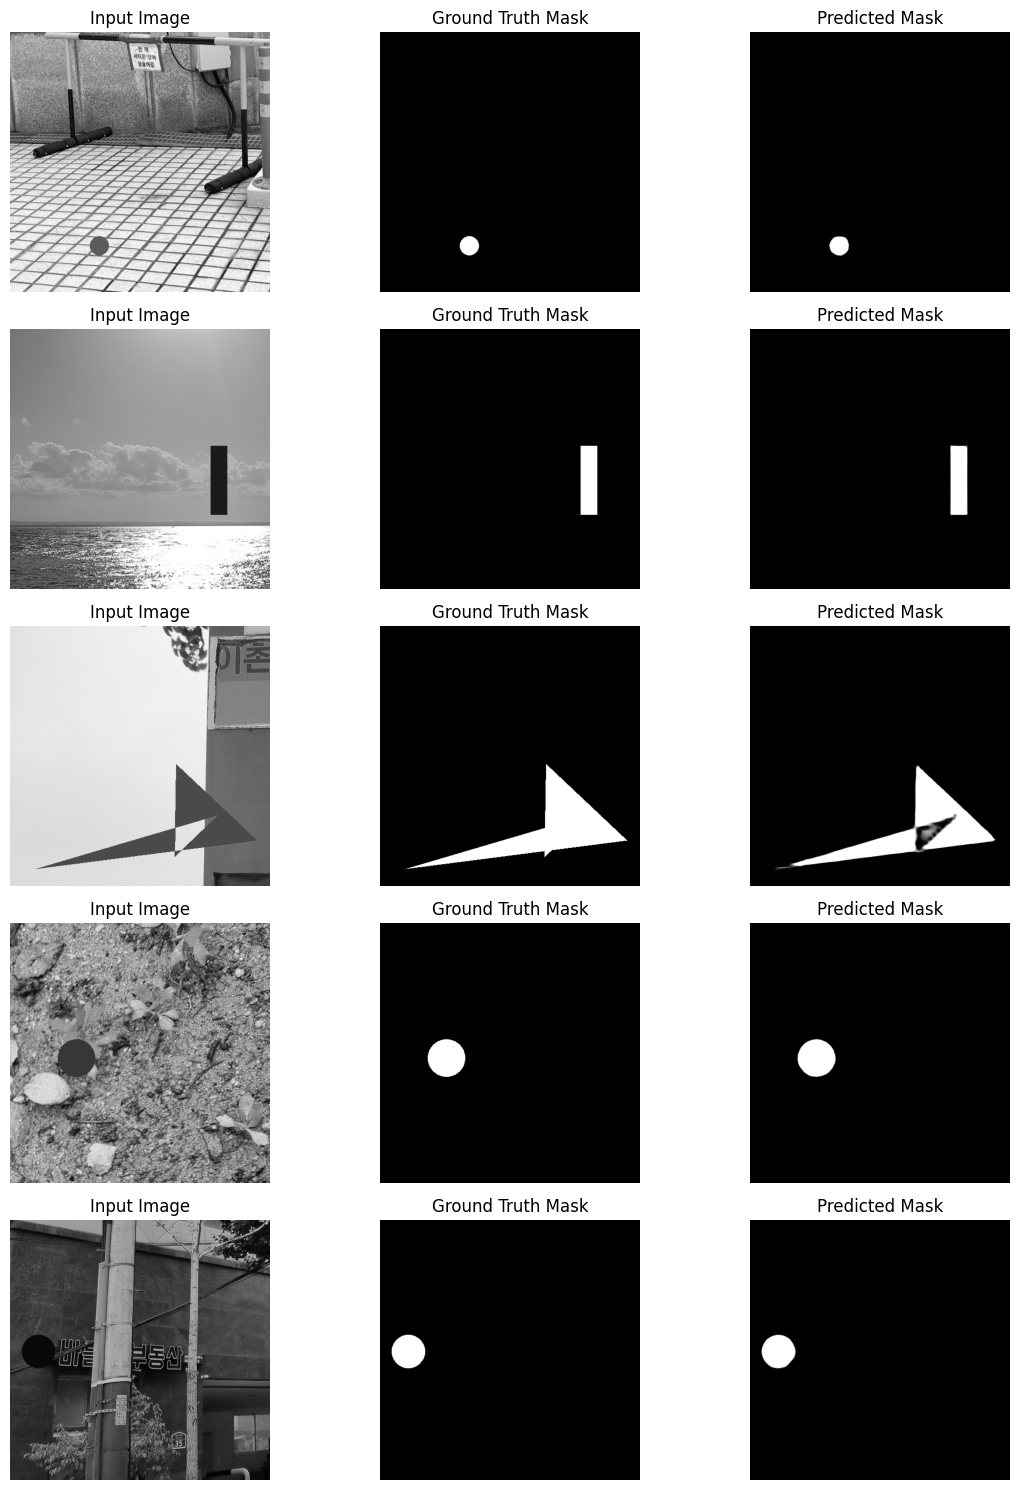

Epoch 12/60 - Validation: 100%|██████████| 198/198 [02:21<00:00,  1.40it/s]


Epoch 12/60
  Training Loss: 0.0025
  Validation Loss: 0.0023


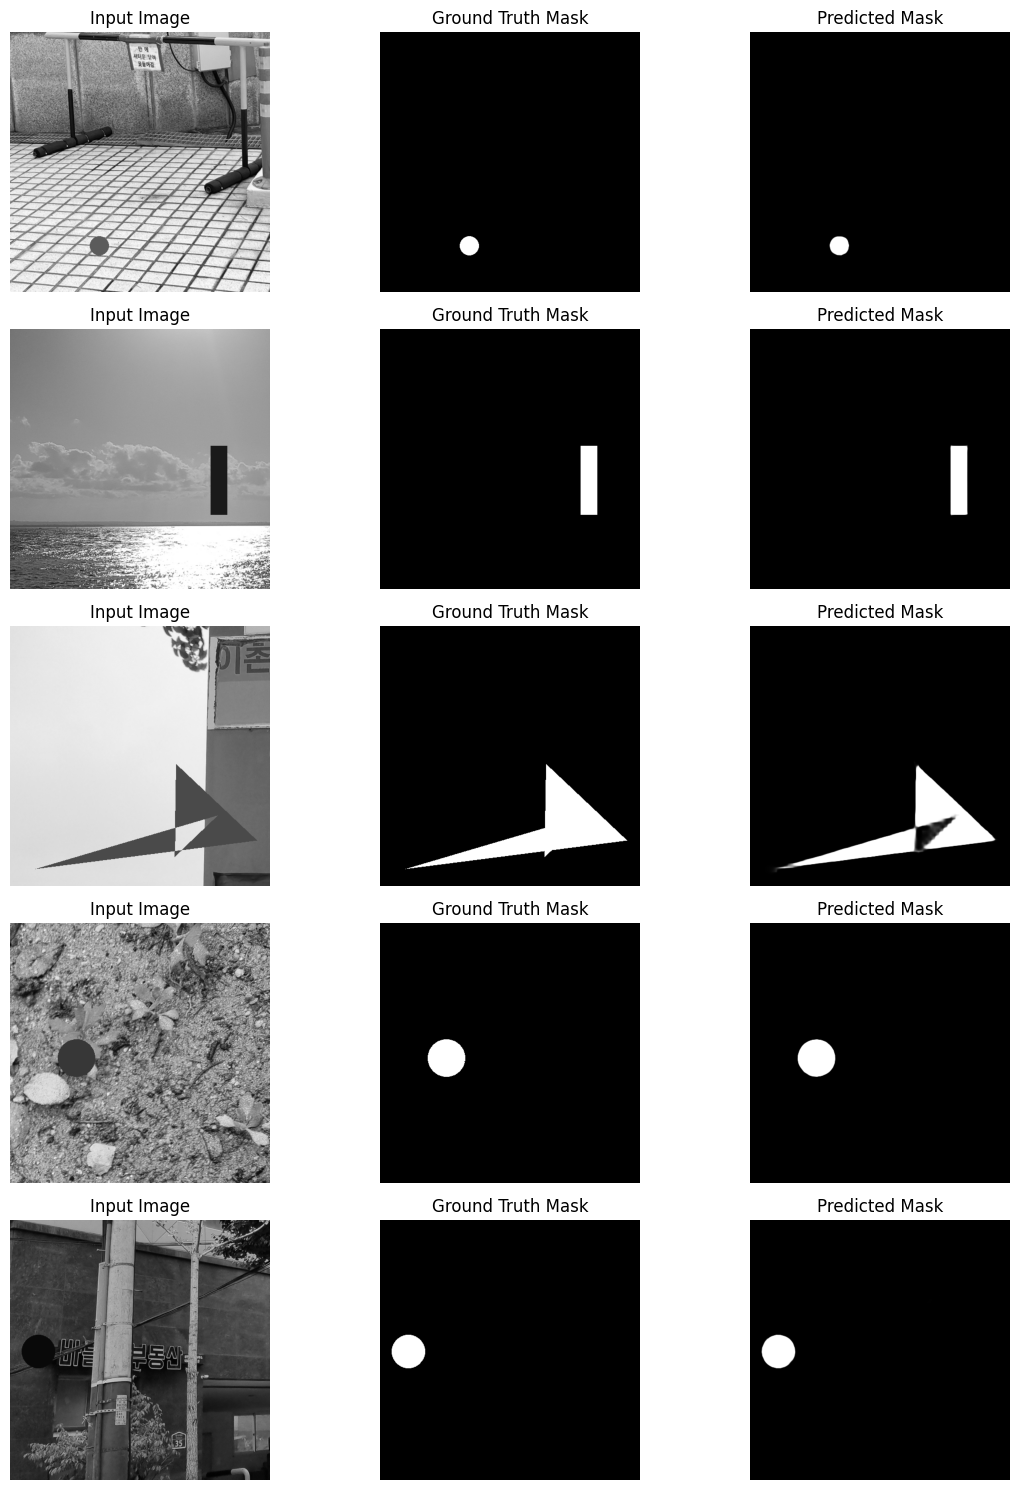

Epoch 13/60 - Validation: 100%|██████████| 198/198 [02:22<00:00,  1.39it/s]


Epoch 13/60
  Training Loss: 0.0028
  Validation Loss: 0.0024


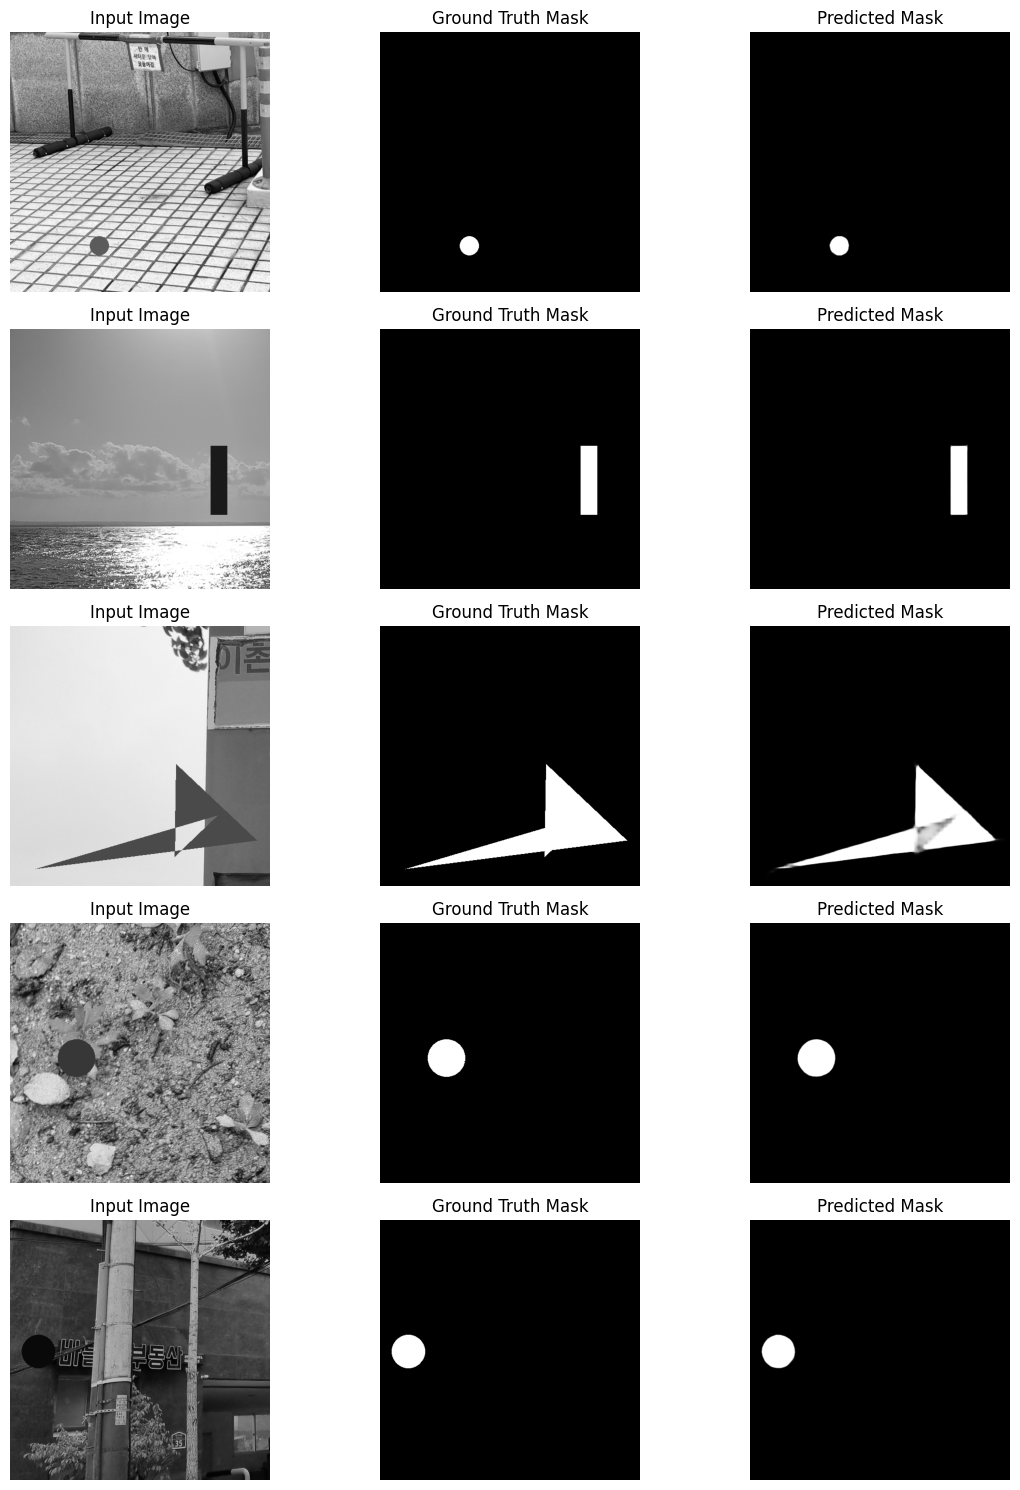

Epoch 14/60 - Validation: 100%|██████████| 198/198 [02:22<00:00,  1.39it/s]


Epoch 14/60
  Training Loss: 0.0020
  Validation Loss: 0.0033


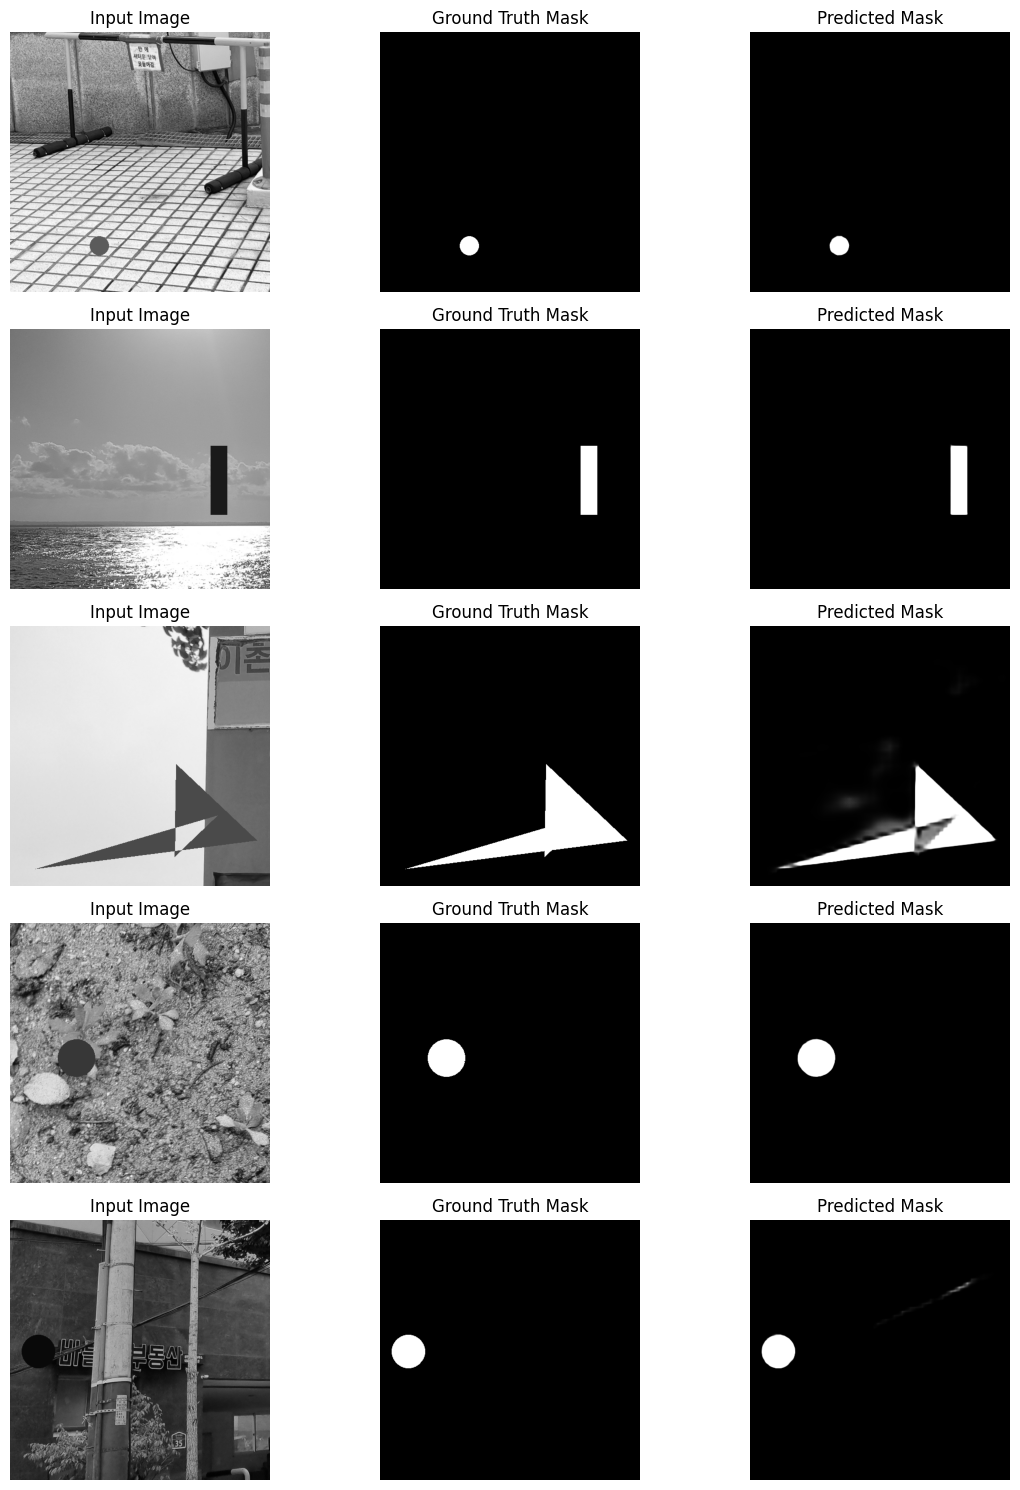

Epoch 15/60 - Training:  52%|█████▏    | 414/790 [08:14<07:29,  1.20s/it]


KeyboardInterrupt: 

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

batch = 30
data_ratio = 1 # 100% 데이터셋사용
num_epochs = 60
test_size=0.2
lr=0.001

from sklearn.model_selection import train_test_split

# =====================================
# 01. 데이터 준비과정
# =====================================

# 데이터를 재사용가능하도록 전 처리 진행
input_dir = '/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_input'
gt_dir = '/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_gt'

image_files = sorted(os.listdir(input_dir))
mask_files = sorted(os.listdir(gt_dir))

# Train-Validation 비율을 8:2로 분리
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=test_size, random_state=42
)

class DamageDataset(Dataset):
    def __init__(self, input_dir, gt_dir, image_files, mask_files, transform=None):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.image_files[idx])
        gt_path = os.path.join(self.gt_dir, self.mask_files[idx])

        input_image = Image.open(input_path).convert("RGB")
        input_image_np = np.array(input_image)
        gt_image_gray = Image.open(gt_path).convert("L")
        gt_image_gray_np = np.array(gt_image_gray)

        input_image_gray_np = cv2.cvtColor(input_image_np, cv2.COLOR_RGB2GRAY)
        difference = cv2.absdiff(gt_image_gray_np, input_image_gray_np)
        _, binary_difference = cv2.threshold(difference, 1, 255, cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        binary_difference = cv2.morphologyEx(binary_difference, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(binary_difference, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled = np.zeros_like(binary_difference)
        cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
        mask_filled = cv2.dilate(mask_filled, kernel, iterations=1)

        input_tensor = transforms.ToTensor()(input_image)
        mask_tensor = torch.tensor(mask_filled, dtype=torch.float32).unsqueeze(0) / 255.0

        return input_tensor, mask_tensor

# Training and Validation Datasets
train_dataset = DamageDataset(input_dir, gt_dir, train_images, train_masks)
val_dataset = DamageDataset(input_dir, gt_dir, val_images, val_masks)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

# =====================================
# 02. 모델 준비과정 / DeepLabV3_ResNet50 사전학습모델사용
# =====================================

# Load model with updated weights parameter
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# GPU 사용 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DataParallel 및 SyncBatchNorm 적용
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs! Model training started...")
    model = nn.DataParallel(model)  # DataParallel로 모델 병렬화
    model = nn.SyncBatchNorm.convert_sync_batchnorm(model)  # SyncBatchNorm 변환

# GPU로 모델 이동
model = model.to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training and Validation Loop

best_val_loss = float('inf')

# =====================================
# 02. 학습과정
# =====================================

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for inputs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, f"best_model_{epoch+1}_{best_val_loss:.4f}.pth")
        print(f"  Best model saved with Validation Loss: {best_val_loss:.4f}")

    # Visualization (Optional)
    with torch.no_grad():
        inputs, masks = next(iter(val_loader))
        inputs, masks = inputs[:5].to(device), masks[:5].to(device)
        predictions = torch.sigmoid(model(inputs)['out'])
        predictions = predictions.cpu().numpy()
        masks = masks.cpu().numpy()
        inputs = inputs.cpu().numpy()

        fig, axes = plt.subplots(5, 3, figsize=(12, 15))
        for i in range(5):
            axes[i, 0].imshow(inputs[i].transpose(1, 2, 0))
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(masks[i][0], cmap="gray")
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis("off")
            axes[i, 2].imshow(predictions[i][0], cmap="gray")
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")
        plt.tight_layout()
        plt.show()
